In [18]:
import matplotlib.pyplot as plt
import wikipedia
import nltk
import string 
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import accuracy_score

In [5]:
df=pd.read_csv('free_mtr_text_data.csv')  
print(df.shape)

#CONVERT FROM STRING LABELS TO INTEGERS 
labels=[]
y1=[]
for label in df["label"]:
    if label not in labels:
        labels.append(label)
        print("index =",len(labels)-1,": label =",label)
    for i in range(0,len(labels)):
        if(label==labels[i]):
            y1.append(i)
y1=np.array(y1)

# CONVERT DF TO LIST OF STRINGS 
textdata=df["text"].to_list()

print("number of text chunks = ",len(textdata))
print(textdata[0:3])


(3610, 2)
index = 0 : label = freeway
index = 1 : label = metro
number of text chunks =  3610
['thinking cat named freeway', 'keilor lodge heavy traffic bothways calder freeway sunshine avenue', 'lot going funniest though literally person horse freeway entrance http co vlxiv7xm8u']


In [6]:
# INITIALIZE COUNT VECTORIZER
vectorizer=CountVectorizer(min_df=5)   

# RUN COUNT VECTORIZER ON OUR COURPUS 
vec=vectorizer.fit_transform(textdata)   
dense=np.array(vec.todense())

#CONVERT TO ONE-HOT VECTORS
maxs=np.max(dense,axis=0)
onehot=np.ceil(dense/maxs)

# DOUBLE CHECK 
print(onehot.shape,y1.shape)

(3610, 1452) (3610,)


(250, 250)
[[0.         0.31980107 0.10206207 ... 0.         0.26726124 0.2236068 ]
 [0.31980107 0.         0.         ... 0.         0.22792115 0.19069252]
 [0.10206207 0.         0.         ... 0.14433757 0.         0.        ]
 ...
 [0.         0.         0.14433757 ... 0.         0.         0.        ]
 [0.26726124 0.22792115 0.         ... 0.         0.         0.23904572]
 [0.2236068  0.19069252 0.         ... 0.         0.23904572 0.        ]]


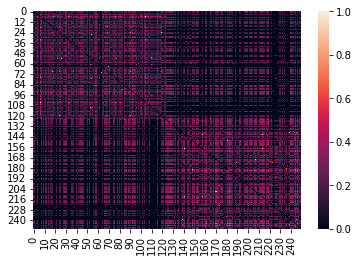

In [14]:
num_rows_keep=250
index=np.sort(np.random.choice(onehot.shape[0], num_rows_keep, replace=False))
tmp1=onehot[index, :]

#COMPUTE DISTANCE MATRIX
dij=[]

#LOOP OVER ROWS
for i in range(0,tmp1.shape[0]):
    tmp2=[]
    #LOOP OVER ROWS
    for j in range(0,tmp1.shape[0]):

        #EXTRACT VECTORS
        vi=tmp1[i,:]
        vj=tmp1[j,:]

        #COMPUTE DISTANCES
        dist=np.dot(vi, vj)/(np.linalg.norm(vi)*np.linalg.norm(vj)) 
        
        # BUILD DISTANCE MATRIX
        if(i==j or np.max(vi) == 0 or np.max(vj)==0):
            tmp2.append(0)
        else:
            tmp2.append(dist)
    dij.append(tmp2)
        
dij=np.array(dij)

import seaborn as sns
sns.heatmap(dij, annot=False)
print(dij.shape)
print(dij)

[0.07631152 0.05441441 0.02341371 0.02087899 0.01296036 0.01039068
 0.00926648 0.00744664 0.00703241 0.00650844]
[43.75546357 36.94827778 24.23663947 22.88716447 18.03208097 16.14579147
 15.24735742 13.66839661 13.28279415 12.7783757 ]


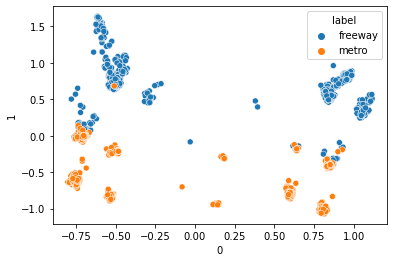

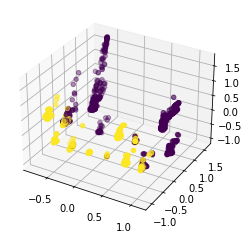

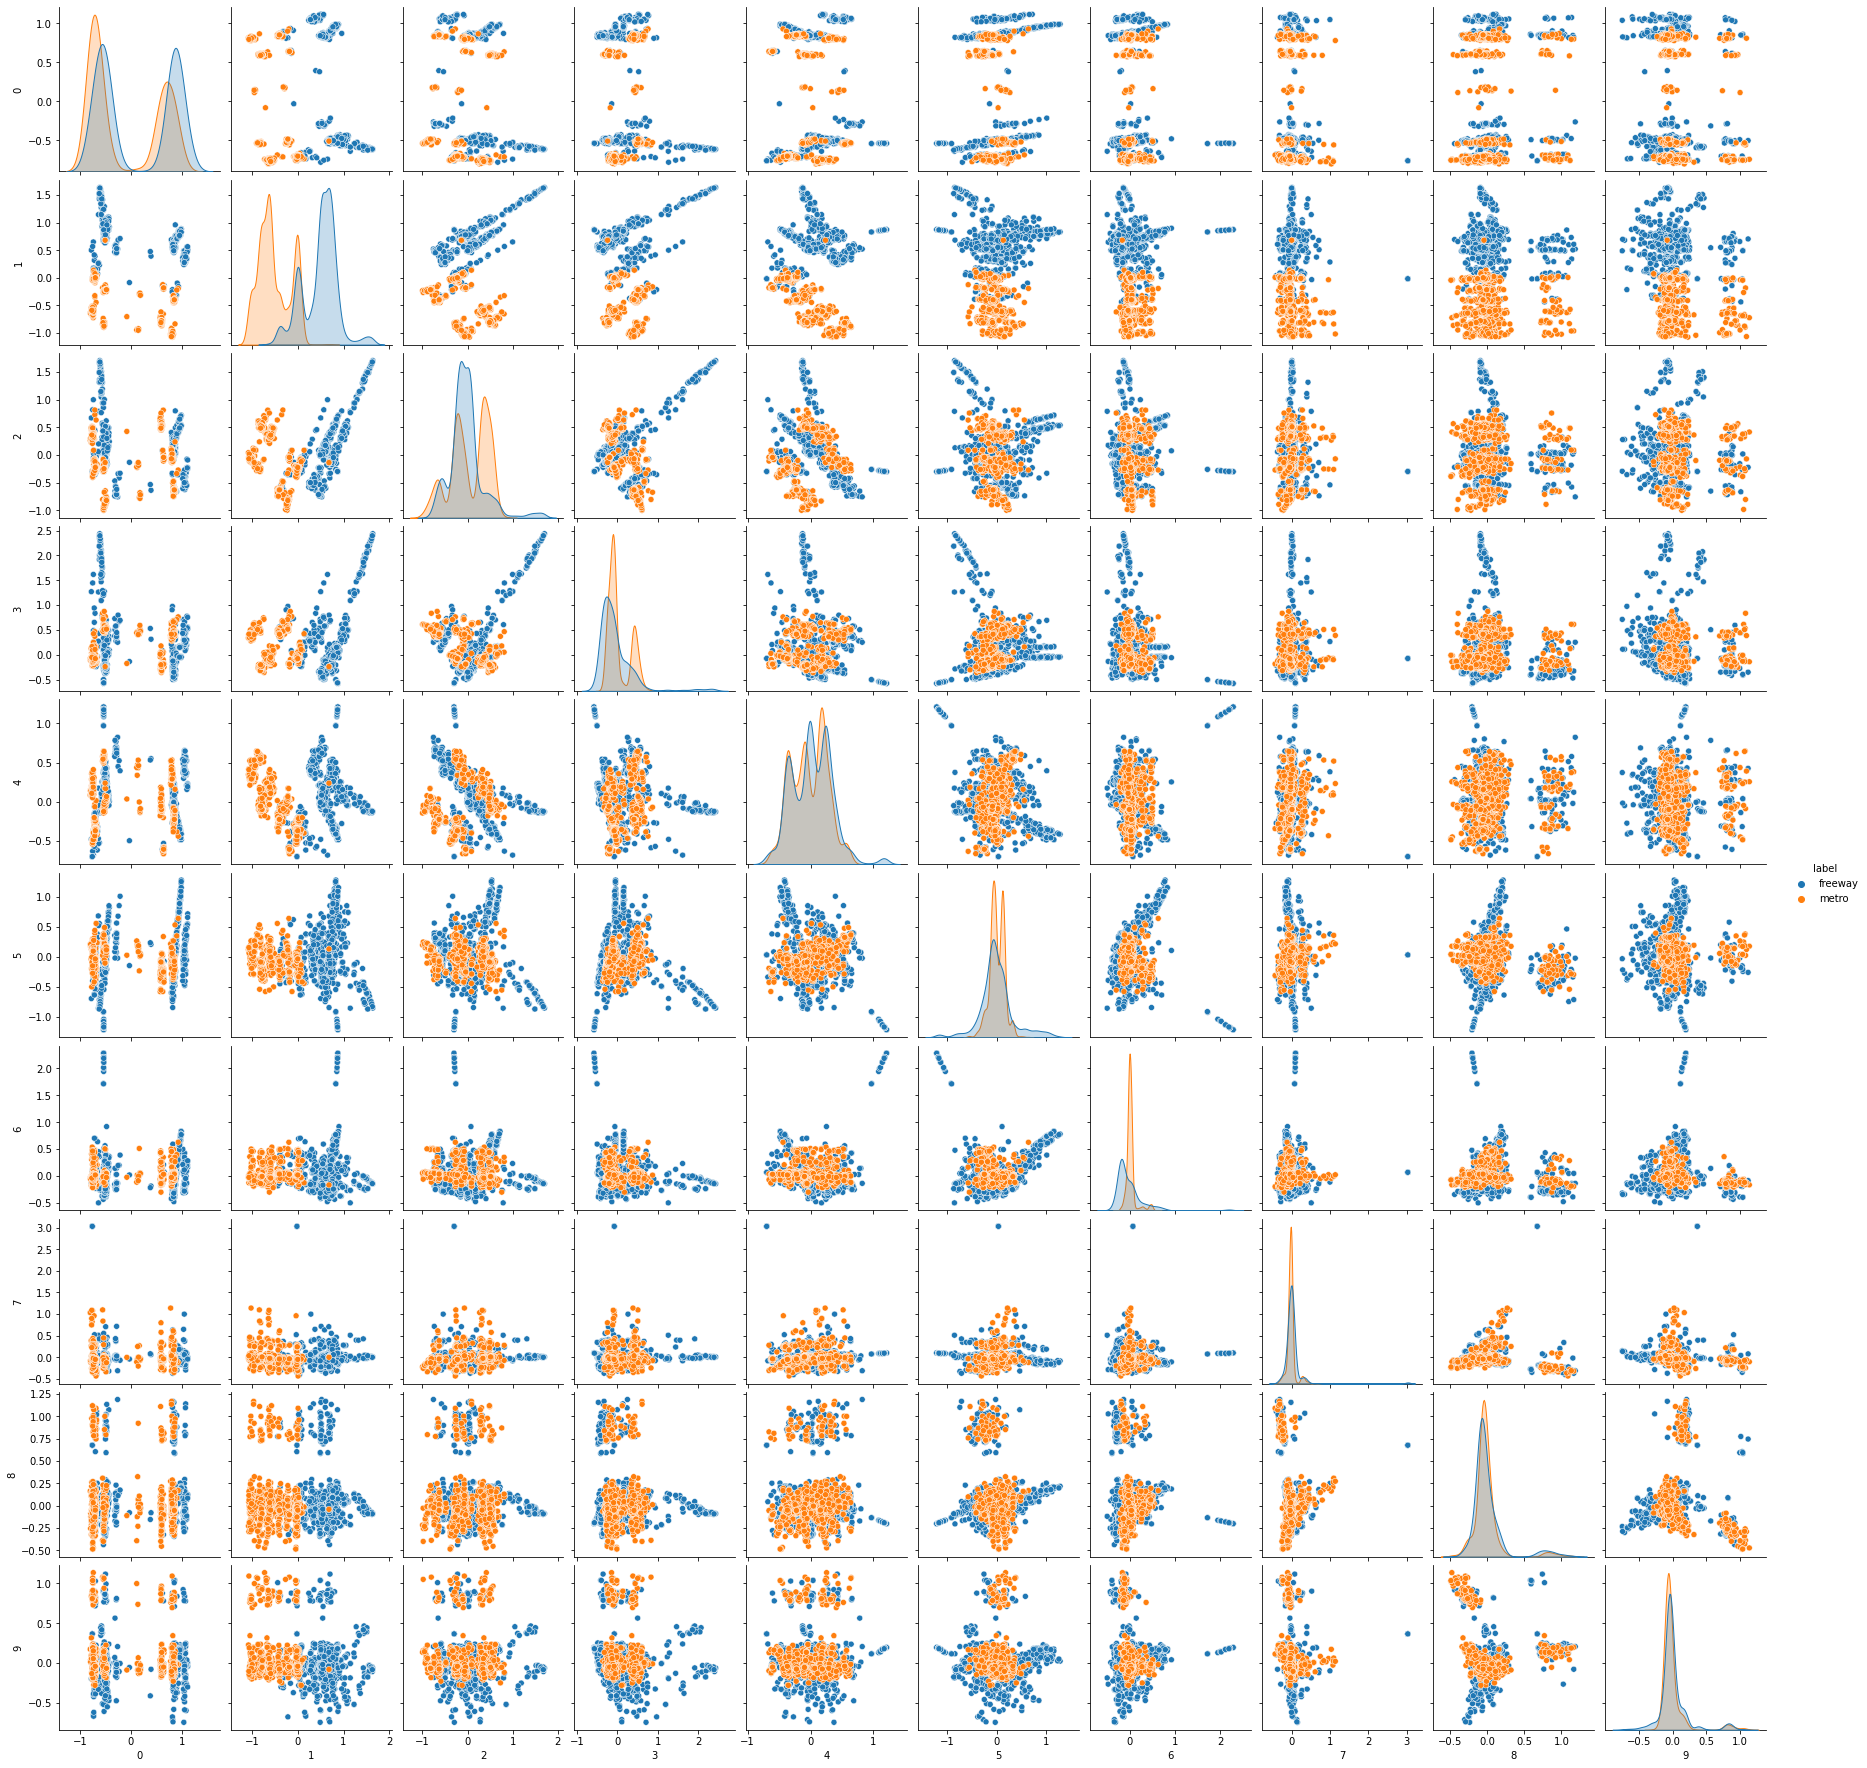

In [17]:
from sklearn.decomposition import PCA

# COMPUTE PCA WITH 10 COMPONENTS
pca = PCA(n_components=10)
pca.fit(onehot)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

# GET PRINCIPLE COMPONENT PROJECTIONS 
principal_components = pca.fit_transform(onehot)
df2 = pd.DataFrame(data = principal_components) #, columns = ['PC1','PC2','PC3','PC4','PC5'])
df3=pd.concat([df2,df['label']], axis=1)

# FIRST TWO COMPONENTS
sns.scatterplot(data=df2, x=0, y=1,hue=df["label"]) 
plt.show()

#3D PLOT
ax = plt.axes(projection='3d')
ax.scatter3D(df2[0], df2[1], df2[2], c=y1);
plt.show()

#PAIRPLOT
sns.pairplot(data=df3,hue="label") #.to_numpy()) #,hue=df["label"]) #, hue="time")
plt.show()


In [19]:
#split to train data and test data

from sklearn.model_selection import train_test_split
X=onehot
test_ratio=0.2
x_train, x_test, y_train, y_test = train_test_split(X, y1, test_size=test_ratio, random_state=0)
y_train=y_train.flatten()
y_test=y_test.flatten()

print("x_train.shape		:",x_train.shape)
print("y_train.shape		:",y_train.shape)

print("X_test.shape		:",x_test.shape)
print("y_test.shape		:",y_test.shape)

x_train.shape		: (2888, 1452)
y_train.shape		: (2888,)
X_test.shape		: (722, 1452)
y_test.shape		: (722,)


In [21]:
def report(y,ypred):
      #ACCURACY COMPUTE 
      print("Accuracy:",accuracy_score(y, ypred)*100)
      print("Number of mislabeled points out of a total %d points = %d"
            % (y.shape[0], (y != ypred).sum()))

def print_model_summary():
      # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
      yp_train = model.predict(x_train)
      yp_test = model.predict(x_test)

      print("ACCURACY CALCULATION\n")

      print("TRAINING SET:")
      report(y_train,yp_train)

      print("\nTEST SET (UNTRAINED DATA):")
      report(y_test,yp_test)

      print("\nCHECK FIRST 20 PREDICTIONS")
      print("TRAINING SET:")
      print(y_train[0:20])
      print(yp_train[0:20])
      print("ERRORS:",yp_train[0:20]-y_train[0:20])

      print("\nTEST SET (UNTRAINED DATA):")
      print(y_test[0:20])
      print(yp_test[0:20])
      print("ERRORS:",yp_test[0:20]-y_test[0:20])

In [22]:
from sklearn.naive_bayes import MultinomialNB

# INITIALIZE MODEL 
model = MultinomialNB()

# TRAIN MODEL 
model.fit(x_train,y_train)

# PRINT REPORT USING UTILITY FUNCTION ABOVE
print_model_summary()

ACCURACY CALCULATION

TRAINING SET:
Accuracy: 94.39058171745152
Number of mislabeled points out of a total 2888 points = 162

TEST SET (UNTRAINED DATA):
Accuracy: 92.38227146814404
Number of mislabeled points out of a total 722 points = 55

CHECK FIRST 20 PREDICTIONS
TRAINING SET:
[0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1]
[0 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 1]
ERRORS: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]

TEST SET (UNTRAINED DATA):
[1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1]
[1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1]
ERRORS: [ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
